# Introduction
This notebook is based of the paper `Detecting Causality in Complex Ecosystems`  By George Sugihara and Robert May. [Suplementary materials](https://www.sciencemag.org/cgi/content/full/science.1227079/DC1) are also available.

In [5]:
import numpy as np
from scipy.interpolate import make_interp_spline

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 10.0)

Let's start by defining some useful functions.

In [6]:
def map_solver(a_function,start, mask, iterations):
    iter_list = []
    current = start
    for i in range(mask):
        current = a_function(current)
    for i in range(iterations):
        iter_list.append([current,a_function(current)])
        current = a_function(current)
        iter_list.append([current,current])
    return np.array(iter_list)

def cobweb(a_function, start, mask = 0, iterations = 20, xmin = 0, xmax = 1):
    '''
    Returns a graphics object of a plot of the function and a cobweb trajectory starting from the value start.

    INPUT:
        a_function: a function of one variable
        start: the starting value of the iteration
        mask: (optional) the number of initial iterates to ignore
        iterations: (optional) the number of iterations to draw, following the masked iterations
        xmin: (optional) the lower end of the plotted interval
        xmax: (optional) the upper end of the plotted interval
    
    EXAMPLES:
        sage: f = lambda x: 3.9*x*(1-x)
        sage: show(cobweb(f,.01,iterations=200), xmin = 0, xmax = 1, ymin=0)
    
    '''
    fig, [ax1,ax2] = plt.subplots(2,1, figsize=(15,10))
    ax1.scatter(start,a_function(start),c='g', s=40) # initial value
    ax1.plot(np.linspace(xmin,xmax,10), np.linspace(xmin,xmax, 10)) # Equilibrium line
    series = map_solver(a_function, start, mask, iterations)
#     series_sm = make_interp_spline(series[:,0],series[:,1])
    ax1.plot(series[:,0],series[:,1], 'r', alpha=0.5, label='Cobweb')
    ax1.set_xlabel('$U_n$')
    ax1.set_ylabel('$U_{n+1}$')
    ax1.legend()
    ax2.plot(series[::2,0])
    ax2.set_xlabel('$U_n$')
    ax2.set_ylabel('$U_{n+1}$')


    

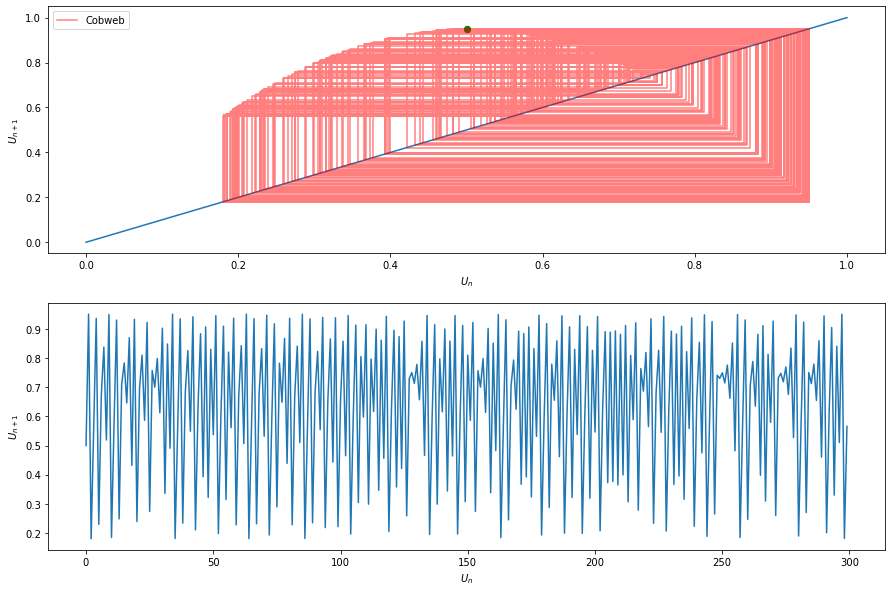

In [7]:
def mapa(x): 
    return 3.8*x*(1-x)
cobweb(mapa, 0.5, mask=0, iterations=300)

## Mirage Correlations
On figure 1 a two dimensional map is shown that although dynamically couple is not always correlated:

\begin{equation}
X_{t+1} = X_t[r_x - r_x X_t -\beta_{x,y} Y_t]\\
Y_{t+1} = Y_t[r_y - r_y Y_t -\beta_{y,x} X_t]
\end{equation}



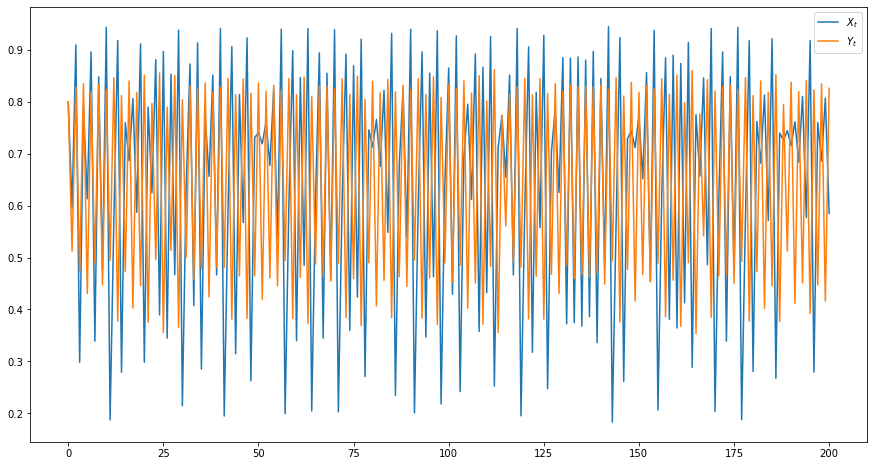

In [8]:
def map_2d(x0, y0, iterations=200):
    pts = [(x0, y0)]
    xi, yi = pts[0]
    rx = 3.8
    ry = 3.5
    betaxy = .02
    betayx = .1
    for i in range(1, iterations + 1):
        xi = xi*(rx-rx*xi-betaxy*yi)
        yi = yi*(ry-ry*yi-betayx*xi)
        pts.append((xi, yi))
    return np.array(pts)

series = map_2d(0.8,0.8)
fig, ax = plt.subplots(1,1, figsize=(15,8))
ax.plot(series)
ax.legend(['$X_t$','$Y_t$']);

### Cross-correlation function
if we look at the cross-correlation function between $X_t$ and $Y_t$, we see that they hold a pretty good 
correlation given the periodic sinchronization windows.

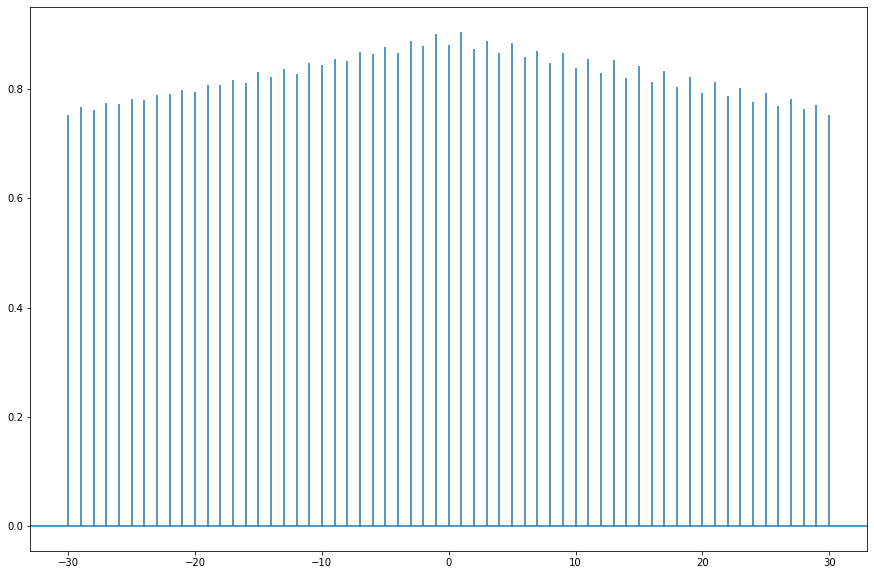

In [9]:
plt.xcorr(series[:,0],series[:,1], maxlags=30);

### Granger Causality
However if we try to estimate causality based on the Granger Causality test. The causality is not statistically significant. This is due to the fact that Granger's test requires separability, that is, the information provided by the causal variable does not contain direct influences from the effect series. This requirement does not hold for coupled dynamical systems.

In [10]:
from statsmodels.tsa.stattools import grangercausalitytests

In [11]:
grangercausalitytests(series, maxlag=2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0277  , p=0.3119  , df_denom=197, df_num=1
ssr based chi2 test:   chi2=1.0434  , p=0.3070  , df=1
likelihood ratio test: chi2=1.0407  , p=0.3077  , df=1
parameter F test:         F=1.0277  , p=0.3119  , df_denom=197, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9373  , p=0.1469  , df_denom=194, df_num=2
ssr based chi2 test:   chi2=3.9745  , p=0.1371  , df=2
likelihood ratio test: chi2=3.9353  , p=0.1398  , df=2
parameter F test:         F=1.9373  , p=0.1469  , df_denom=194, df_num=2


{1: ({'ssr_ftest': (1.0277170404029559, 0.31193894258562155, 197.0, 1),
   'ssr_chi2test': (1.0433675537085847, 0.30703955936554833, 1),
   'lrtest': (1.0406554424187107, 0.3076690823395882, 1),
   'params_ftest': (1.0277170404029832, 0.311938942585611, 197.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.9373172448416367, 0.14686747051823398, 194.0, 2),
   'ssr_chi2test': (3.974496203334904, 0.1370721154274199, 2),
   'lrtest': (3.9353268797003693, 0.1397830865278543, 2),
   'params_ftest': (1.937317244841599, 0.14686747051823984, 194.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

## Convergent Cross Mapping
The method proposed by the paper,  called CCM, aims to estimates states across variables, differently to what we didi in the [Nonlinear Timeseries Analysys](https://github.com/fccoelho/sistemas_dinamicos_aplicados/blob/master/Sage/Nonlinear%20Timeseries%20Analysis.ipynb) notebook.

To implement the Convergent cross mapping  we first need to reconstuct the so-called "shadow manifold" of the varible $X_t$, which is the delayed phase plot we learned how to do before, of one of putative causal variable.

If we use the 2-dimensional system presented above as an example, we can start by taking a look at its true attractor manifold.

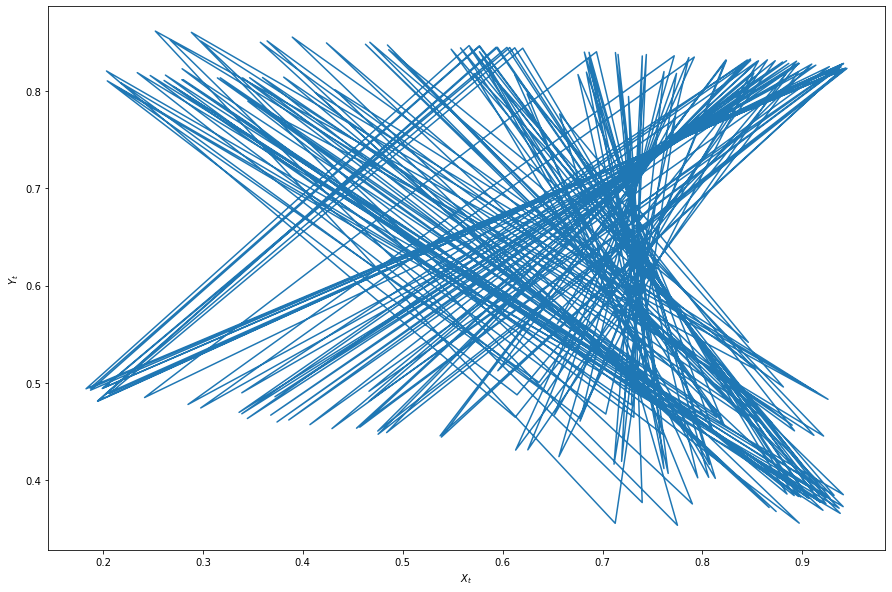

In [12]:
plt.plot(series[:,0], series[:,1])
plt.xlabel('$X_t$')
plt.ylabel('$Y_t$');

First we have to estimate the parameters for the reconstruction. For that we will use the neurokit2 library

In [13]:
import neurokit2 as nk

{'delay': 8, 'dimension': 6, 'r': 0.18809093257494888}

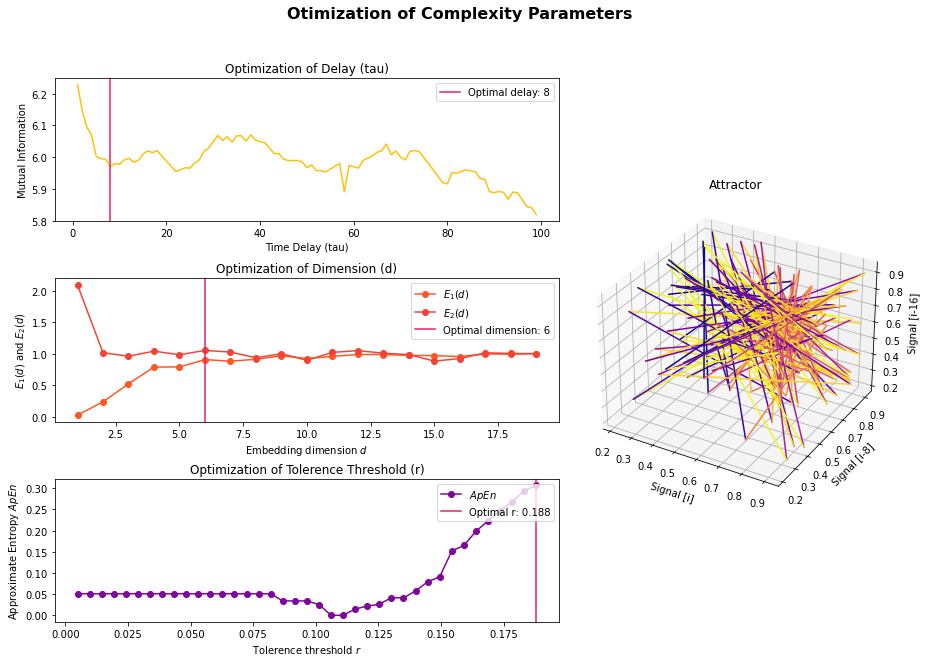

In [14]:
parameters = nk.complexity_optimize(series[:,0], show=True)
parameters

Our shadow manifold, $M_x$, will have a $\tau=8$ and $6$ dimensions

In [15]:
import pandas as pd

In [16]:
data = pd.DataFrame(data={'X':series[:,0]})
tau = 8
data['lag1'] = data.X.shift(1*tau)
data['lag2'] = data.X.shift(2*tau)
data['lag3'] = data.X.shift(3*tau)
data['lag4'] = data.X.shift(4*tau)
data['lag5'] = data.X.shift(5*tau)
data = data.dropna()
data

,X,lag1,lag2,lag3,lag4,lag5
40,0.941251,0.872876,0.389467,0.686508,0.848110,0.800000
41,0.194535,0.407148,0.896909,0.806283,0.475383,0.595200
42,0.593555,0.913518,0.344983,0.587030,0.943447,0.909461
43,0.906707,0.285107,0.853236,0.911611,0.187220,0.297840
44,0.314526,0.771795,0.467087,0.298058,0.576388,0.791875
...,...,...,...,...,...,...
196,0.279202,0.726026,0.280321,0.896100,0.288473,0.620147
197,0.760147,0.744330,0.762065,0.338942,0.775010,0.884674
198,0.686033,0.715525,0.681817,0.848256,0.657126,0.380876
199,0.807039,0.761497,0.812924,0.475017,0.845977,0.889871


According to the CCM methodology, the crossmap estimate of $Y_t$, is the weighted average of the $Y_t$ values corresponding to the reconstructed $x_t$ nearest $E+1$ neighbors.

\begin{equation*}
\hat{Y}_t\mid M_x = \sum w_i Y_{t_i}
\end{equation*}

Where the weights are a function of the euclidean distance of $x_t$ and each neighbor.

This definition is pratically the same as a K-Nearest Neighbor regression, So let's use $M_x$ to estimate the corresponding value of $Y_t$

In [17]:
from sklearn.neighbors import KNeighborsRegressor

In [18]:
n_neighbors = 3
X = data[['X','lag1','lag2', 'lag3','lag4','lag5']]
y = series[:,1][5*tau:]
knn = KNeighborsRegressor(n_neighbors, weights='distance')
y_ = knn.fit(X, y).predict(X)

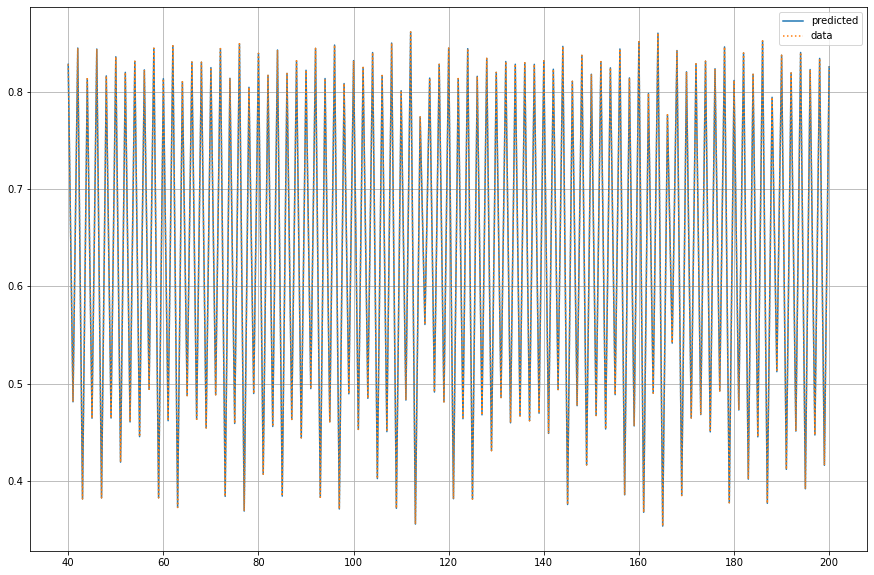

In [19]:
plt.plot(data.index,y_, label='predicted')
plt.plot(data.index,y,':',label='data')
plt.grid()
plt.legend();

In [20]:
knn.score(X,y)

1.0

Let's do it in the other direction, Using $M_y$ to estimate $X_t$.

In [21]:
dataY = pd.DataFrame(data={'Y':series[:,1]})
dataY['lag1'] = dataY.Y.shift(1*tau)
dataY['lag2'] = dataY.Y.shift(2*tau)
dataY['lag3'] = dataY.Y.shift(3*tau)
dataY['lag4'] = dataY.Y.shift(4*tau)
dataY['lag5'] = dataY.Y.shift(5*tau)
dataY = dataY.dropna()
dataY

,Y,lag1,lag2,lag3,lag4,lag5
40,0.828474,0.831322,0.855630,0.839980,0.833097,0.800000
41,0.481250,0.456942,0.355604,0.402721,0.447058,0.512384
42,0.845205,0.826769,0.789757,0.818238,0.823013,0.827864
43,0.381283,0.477706,0.513759,0.445945,0.494412,0.474111
44,0.813679,0.836391,0.850340,0.851481,0.846393,0.835111
...,...,...,...,...,...,...
196,0.823073,0.794529,0.811820,0.828980,0.860523,0.844245
197,0.447118,0.512246,0.472824,0.468106,0.353391,0.385545
198,0.834539,0.837823,0.840177,0.831732,0.776548,0.814466
199,0.415943,0.411766,0.401678,0.450329,0.541630,0.456413


In [22]:
n_neighbors = 3
X = dataY[['Y','lag1','lag2', 'lag3','lag4','lag5']]
y = series[:,0][5*tau:]
knn2 = KNeighborsRegressor(n_neighbors, weights='distance')
y_ = knn2.fit(X, y).predict(X)

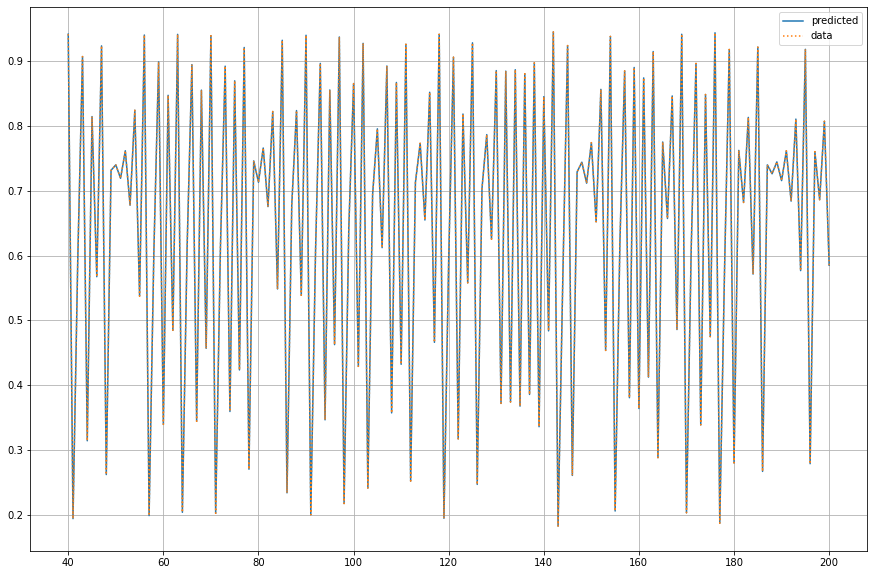

In [23]:
plt.plot(dataY.index,y_, label='predicted')
plt.plot(dataY.index,y,':',label='data')
plt.grid()
plt.legend();

## A More Complex Model
With the two species coupled model the causality was very easy to demonstrate. So let' try with the 5-species model from the article's supplementary material. 

\begin{align}
Y_1(t+1) &= Y_1(t) \left[4 – 4 Y_1(t) – 2 Y_2(t) – 0.4 Y_3(t)\right]\\
Y_2(t+1) &= Y_2(t) [3.1 – 0.31 Y_1(t) – 3.1 Y_2(t) – 0.93 Y_3(t)]\\
Y_3(t+1) &= Y_3(t) [2.12 + 0.636 Y_1(t) + 0.636 Y_2(t) – 2.12 Y_3 (t)]\\
Y_4(t+1) &= Y_4(t) [3.8 – 0.111 Y_1(t) – 0.011 Y_2(t) + 0.131 Y_3(t) – 3.8 Y_4(t)]\\
Y_5(t+1) &= Y_5(t) [4.1 – 0.082 Y_1(t) – 0.111 Y_2(t) – 0.125 Y_3(t) – 4.1Y_5(t)]
\end{align}


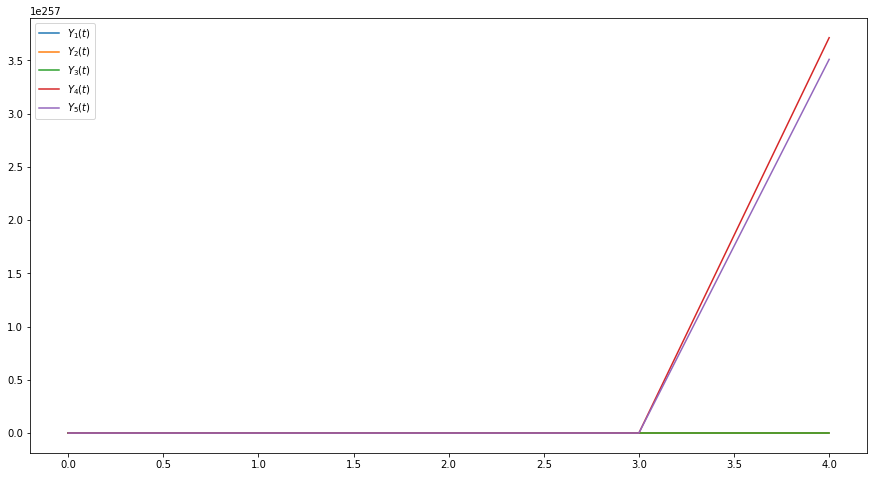

In [147]:
def map_5d(inits, iterations=200):
    pts = [inits]
    y1, y2, y3, y4, y5 = pts[0]

    for i in range(1, iterations + 1):
        y1 = y1 * (4 - 4 * y1 - 2 * y2 - 0.4 * y3)
        y2 = y2 * (3.1 - .31 * y1 - 3.1 * y2 - .93 * y3)
        y3 = y3 * (2.12 + .636 * y1 + .636 * y2 - 2.12 * y3)
        y4 = y4 * (3.8 - .111 * y1 - .011 * y2 + .131 * y3 - 3.8 * y4)
        y5 = y5 * (4.1 - .082 * y1 - .111 * y2 - .125 * y3 - 4.1 * y5)

        pts.append((y1, y2, y3, y4, y5))
    return np.array(pts)


series5 = map_5d((10.8, 100.8, 10.8,10.8,10.8),4)
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot(series5)
ax.legend([f'$Y_{i}(t)$' for i in range(1,6)]);

Unfortunately the article does not give initial values for this model and it is quite unstable.

## Coupled Rossler-Lorenz
For this example we will couple 2 chaotic oscillators, with the parameter $C$ meaning the strength of this coupling. The Rossler System is given by the following system of Equations:
\begin{align}
\frac{dU}{dt} &= -a(V+W)\\
\frac{dV}{dt} &= a (U+0.2 V)\\
\frac{dW}{dt} &= a(0.2+W(U-5.7))
\end{align}

The Lorenz oscillator is given below:

\begin{align}
\frac{dX}{dt} &= 10(-X+Y)\\
\frac{dY}{dt} &= 28X-Y-XZ+CV^2\\
\frac{dZ}{dt} &= XY-\frac{8}{3} Z
\end{align}

where $C$ is the strength of the unidirectional coupling between the two attractors and $a$
controls the characteristic timescale of the driving system.

In [24]:
from scipy.integrate import odeint

In [25]:
def rossler_lorenz(state,t):
    U,V,W,X,Y,Z = state
    a=6.0
    C=2.0
    return [
        -a*(V+W),
        a*(U+.2*V),
        a*(.2+W*(U-5.7)),
        10*(-X+Y),
        28*X-Y-X*Z+C*V**2,
        X*Y-(8/3)*Z
    ]

In [26]:
inits = [4,4,5, 2,3,4]
trange = range(1000)
res = odeint(rossler_lorenz,inits,trange)

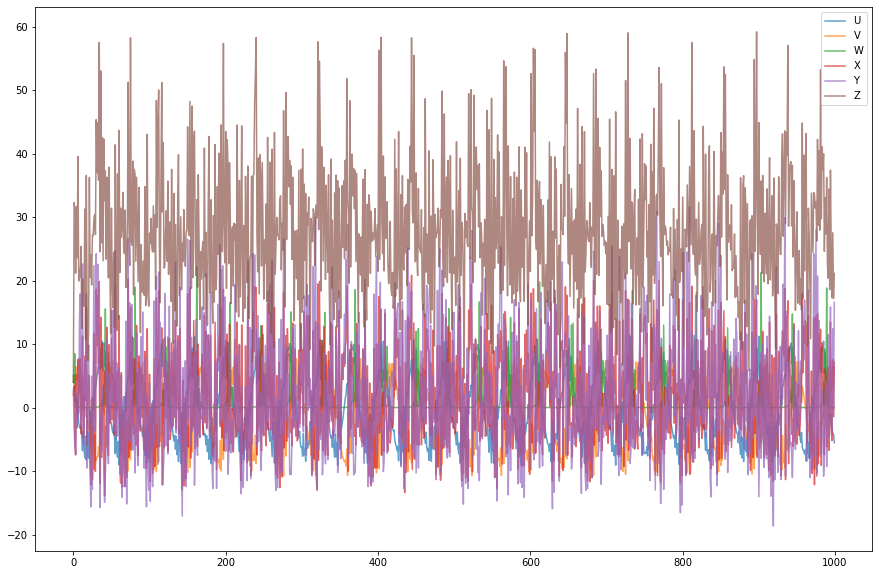

In [27]:
plt.plot(res, alpha=0.7)
plt.legend(['U','V','W','X','Y','Z']);

### Estimating the complexity parameters

{'delay': 2, 'dimension': 4, 'r': 1.7532200842577184}

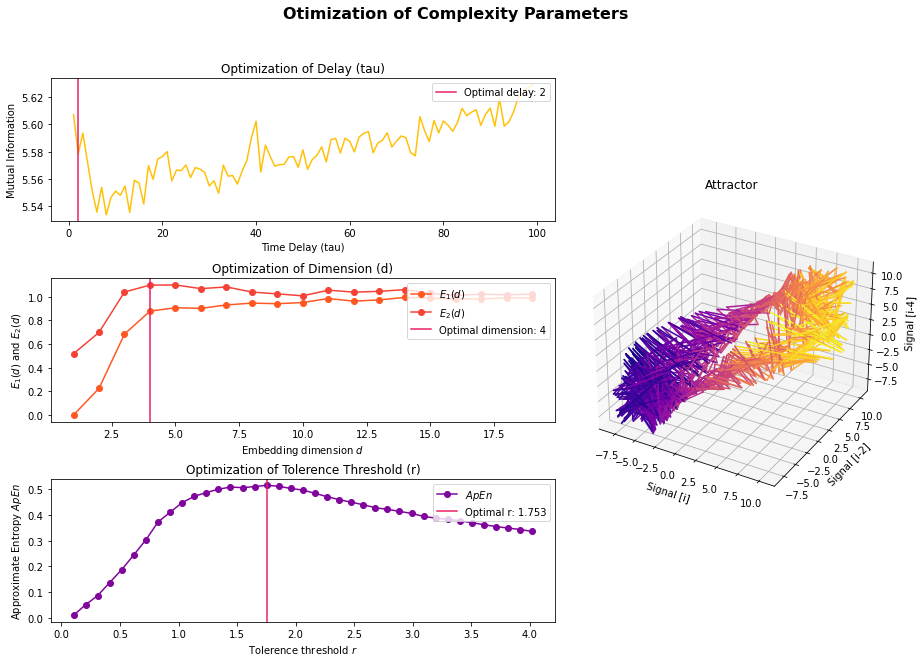

In [34]:
parameters = nk.complexity_optimize(res[:,0], show=True)
parameters

In [37]:
dataY = pd.DataFrame(data={'Y':res[:,0]})
tau = 4
dataY['lag1'] = dataY.Y.shift(1*tau)
dataY['lag2'] = dataY.Y.shift(2*tau)
dataY['lag3'] = dataY.Y.shift(3*tau)
# dataY['lag4'] = dataY.Y.shift(4*tau)
#dataY['lag5'] = dataY.Y.shift(5*tau)
dataY = dataY.dropna()
dataY

,Y,lag1,lag2,lag3
12,-6.769491,-3.066061,1.377345,4.000000
13,-3.723619,-3.261972,-1.126997,5.158566
14,-6.590851,-2.691293,-0.096333,0.925384
15,-7.933340,-4.580736,-2.402518,0.920742
16,-4.519114,-6.769491,-3.066061,1.377345
...,...,...,...,...
995,-2.723521,3.487124,8.733308,9.567693
996,-3.394343,-1.379996,5.443436,8.895742
997,-4.008213,-1.831535,4.235494,10.469113
998,-4.168120,-1.118181,1.217029,5.398911


In [38]:
n_neighbors = 3
X = dataY[['Y','lag1','lag2', 'lag3']]
y = res[:,3][3*tau:]
knn2 = KNeighborsRegressor(n_neighbors, weights='distance')
y_ = knn2.fit(X, y).predict(X)

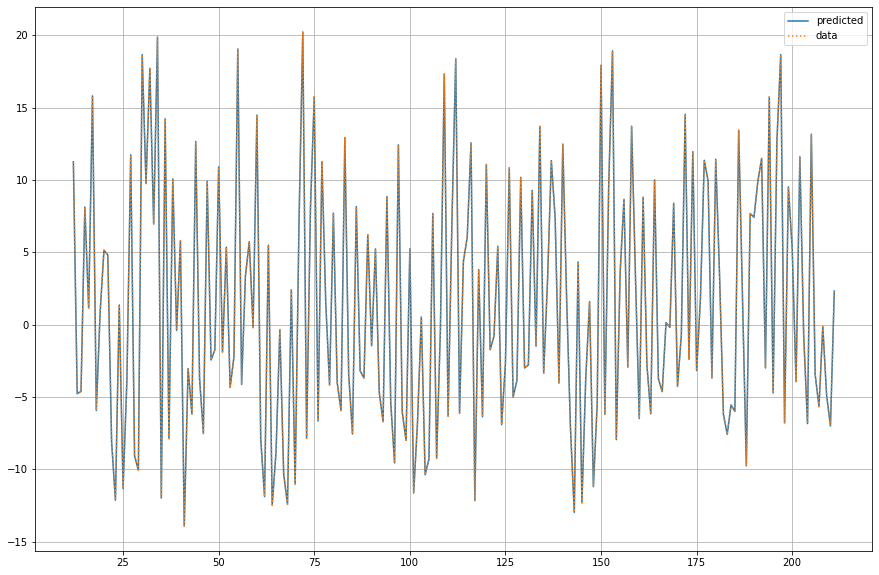

In [41]:
plt.plot(dataY.index[:200],y_[:200], label='predicted')
plt.plot(dataY.index[:200],y[:200],':',label='data')
plt.grid()
plt.legend();

In [40]:
knn2.score(X,y)

1.0

{'delay': 4, 'dimension': 7, 'r': 6.6090606417046756}

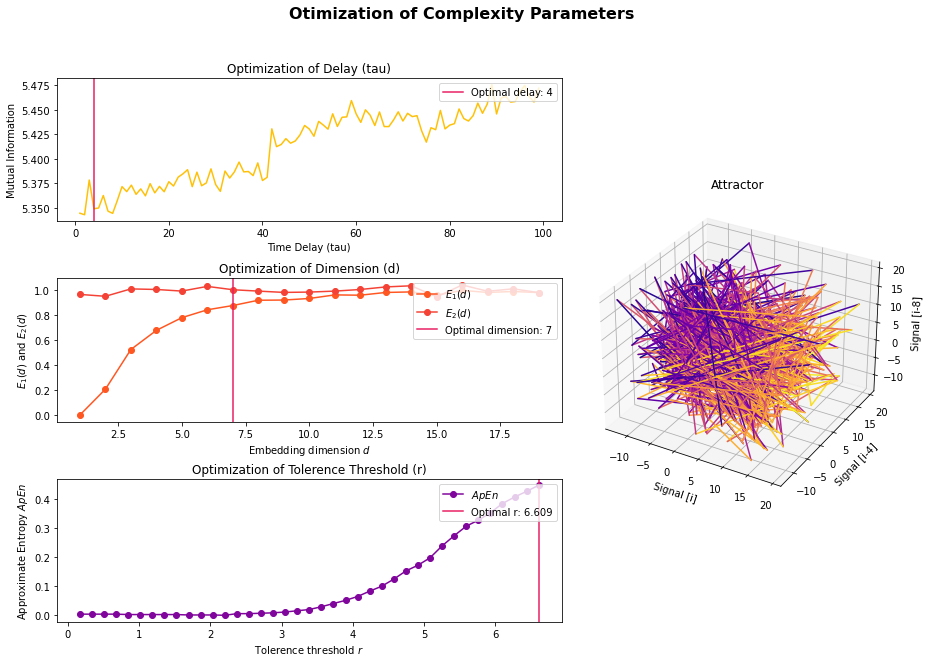

In [35]:
parameters = nk.complexity_optimize(res[:,3], show=True)
parameters

In [58]:
dataY = pd.DataFrame(data={'Y':res[:,3]})
tau = 4
dataY['lag1'] = dataY.Y.shift(-1*tau)
dataY['lag2'] = dataY.Y.shift(-2*tau)
dataY['lag3'] = dataY.Y.shift(-3*tau)
dataY['lag4'] = dataY.Y.shift(-4*tau)
dataY['lag5'] = dataY.Y.shift(-5*tau)
dataY['lag6'] = dataY.Y.shift(-6*tau)
dataY = dataY.dropna()
dataY

,Y,lag1,lag2,lag3,lag4,lag5,lag6
0,2.000000,5.218787,7.731789,11.261450,1.145676,5.148534,1.361099
1,3.429989,-3.160492,7.647185,-4.767073,15.815773,4.825407,-11.323044
2,-5.240746,7.626884,-4.105722,-4.612609,-5.927898,-8.097106,-3.816433
3,-7.387151,-0.838154,0.794006,8.135552,0.870380,-12.135309,11.741855
4,5.218787,7.731789,11.261450,1.145676,5.148534,1.361099,-9.054076
...,...,...,...,...,...,...,...
971,-4.975944,14.367167,11.495618,10.204884,6.112633,6.381869,-3.902498
972,14.147940,-10.761839,6.089932,7.015094,5.499279,-6.722969,-5.164293
973,-12.148159,14.797793,12.342263,2.350346,-6.185271,0.143675,7.559364
974,6.394219,-8.797179,-9.113217,-7.428381,-4.289708,13.460467,-1.426988


In [60]:
n_neighbors = 3
X = dataY[['Y','lag1','lag2', 'lag3', 'lag4', 'lag5', 'lag6']]
y = res[:,0][:-6*tau]
knn2 = KNeighborsRegressor(n_neighbors, weights='distance')
y_ = knn2.fit(X, y).predict(X)

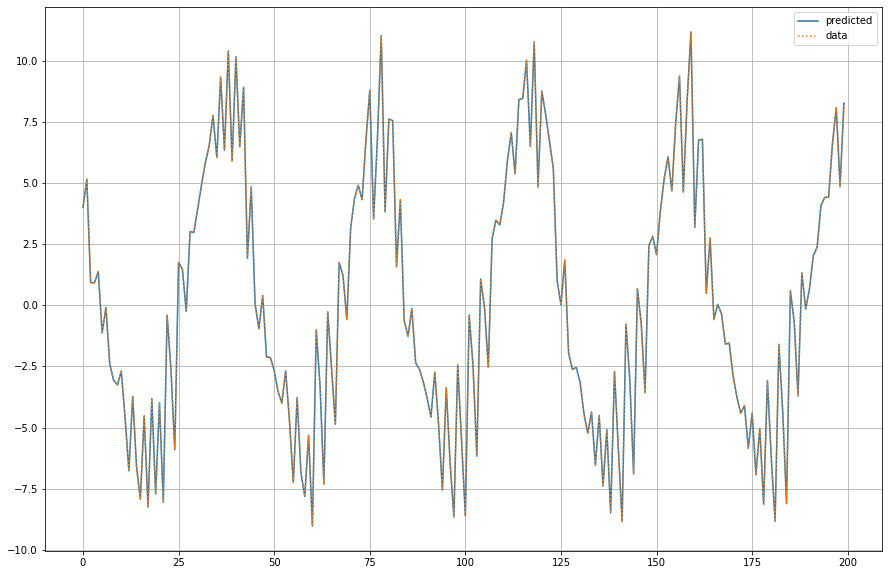

In [61]:
plt.plot(dataY.index[:200],y_[:200], label='predicted')
plt.plot(dataY.index[:200],y[:200],':',label='data')
plt.grid()
plt.legend();

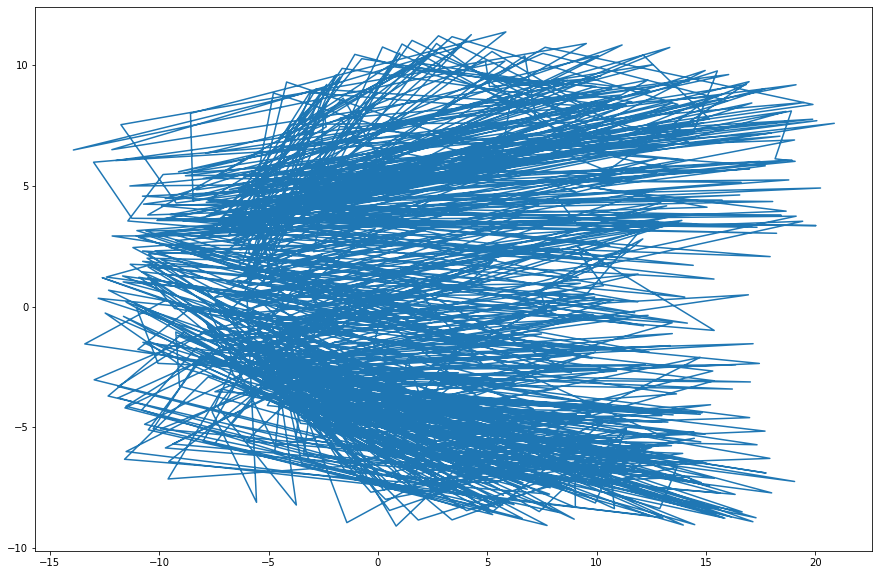

In [48]:
knn2.score(X,y)

1.0